# Supervised learning with Rigetti 8Q

Classification of points on 2D plane using a 2-qubit quantum circuit. Here we encode a 2-dimensional vector $(\theta_1, \theta_2)$ into a 2-qubit state, and use a parametrized circuit to perform further classification.

The circuit is the following:

<img src="qnn_circuit3.png" width="50%">

The first part is an encoding circuit that serves as a feature map which maps a data point $(\theta_1,\theta_2)$ into a 2-qubit state. The second part is a classifier which produces the output as the probability $p$ of measuring $|0\rangle$ in the top qubit.

References:

[Google] The set up of quantum neural network: https://arxiv.org/abs/1802.06002

[Microsoft] The encoding idea: https://arxiv.org/abs/1804.00633

[IBM] The ansatz design: https://arxiv.org/abs/1804.11326

In [1]:
# Basic parameters
import numpy as np
import matplotlib.pyplot as plt

from pyquil.api import (CompilerConnection, get_devices,
                        QVMConnection, QPUConnection)
from pyquil.quil import Program
from pyquil.gates import *

from math import *

# Function running the quantum circuit
def qnn(input_vec, params, qubits_chosen):
    
    """
    Args:
        input_vec - the 2D input vector to be classified
        params - the parameters for the classification circuit
        qubits_chosen - indices of the chosen qubits
    
    Returns:
        A program object describing the circuit
    """
    
    t0 = input_vec[0]
    t1 = input_vec[1]
    
    p0 = params[0]
    p1 = params[1]
    # p2 = params[2]
    # p3 = params[3]
    
    q0 = qubits_chosen[0]
    q1 = qubits_chosen[1]
    
    program = Program(
            RX(t0, q0),
            RX(t1, q1),
            CZ(q0, q1), # Encoding circuit
            RX(p0, q0),
            RX(p1, q1),
            # CZ(q0, q1), # Classifier circuit
            MEASURE(q0, 0),
            MEASURE(q1, 1)
        )
    
    return program

Now we run one instance of the circuit on the QPU with randomly assigned parameters.

In [2]:
# Test run the circuit

DEVICE_NAME = '8Q-Agave'
N_RUNS = 10000

input_vec = [0.1, -0.2]
params = [np.random.uniform(-pi/2, pi/2) for x in range(0,4)]
qubits_chosen = [0,1]

qnn_prog = qnn(input_vec, params, qubits_chosen)

# Set up device and compiler
devices = get_devices(as_dict=True)
device = devices[DEVICE_NAME]
compiler = CompilerConnection(device)
    
# Submit compilation job
compiler_job_id = compiler.compile_async(qnn_prog)
completed_job = compiler.wait_for_job(compiler_job_id)

# Display post-compilation info
print("Compiled Quil Program:")
compiled_program = completed_job.compiled_quil()
print(compiled_program)
print("\nGate volume           : {}".format(completed_job.gate_volume()))
print("Gate depth            : {}".format(completed_job.gate_depth()))
print("Topological SWAPs     : {}".format(completed_job.topological_swaps()))
print("Program fidelity      : {}".format(completed_job.program_fidelity()))
print("Multiqubit gate depth : {}".format(completed_job.multiqubit_gate_depth()))

qpu = QPUConnection(device)
qpu_job_id = qpu.run_async(qnn_prog, qubits_chosen, N_RUNS)
print("\nJob ID: {}".format(qpu_job_id))
    
count = 0
while not qpu.get_job(qpu_job_id).is_done():
    count += 1

qpu_result = qpu.get_job(qpu_job_id).result()
qpu_prob = float(qpu_result.count([1, 0])+qpu_result.count([1, 1]))/float(N_RUNS)
print("\nProbability: {}".format(qpu_prob))

job BmOoHFshPJmPYuce is currently compiling
Compiled Quil Program:
PRAGMA EXPECTED_REWIRING "#(0 1 2 3 4 5 6 7)"
RZ(pi/2) 0
RX(pi/2) 0
RZ(0.1) 0
RX(-pi/2) 0
RZ(pi/2) 1
RX(pi/2) 1
RZ(-0.2) 1
RX(-pi/2) 1
CZ 0 1
RX(pi/2) 0
RZ(-1.1643375670017932) 0
RX(-pi/2) 0
RZ(-pi/2) 0
RX(pi/2) 1
RZ(-1.0421876317523981) 1
RX(-pi/2) 1
RZ(-pi/2) 1
PRAGMA CURRENT_REWIRING "#(0 1 2 3 4 5 6 7)"
PRAGMA EXPECTED_REWIRING "#(0 1 2 3 4 5 6 7)"
MEASURE 0 [0]
MEASURE 1 [1]
PRAGMA CURRENT_REWIRING "#(0 1 2 3 4 5 6 7)"


Gate volume           : 17
Gate depth            : 9
Topological SWAPs     : 0
Program fidelity      : 0.6966407361909048
Multiqubit gate depth : 1

Job ID: tKYbkEHCMBeLzyUA

Probability: 0.0007


## Linearly inseparable data

We generate synthetic data points in 2D that are linearly inseparable

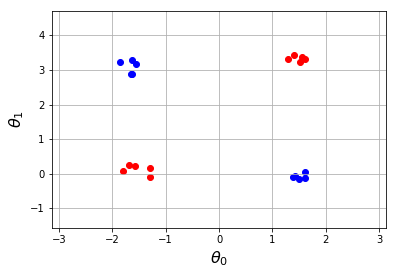

In [6]:
# Generate linearly separable data
Ndata = 5 # Number of data points per point group
delta = pi/10 # range of perturbation
#group0 = [[-pi/2+np.random.uniform(-delta,delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)]\
#        + [[pi/2+np.random.uniform(-delta,delta), pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
#group1 = [[-pi/2+np.random.uniform(-delta,delta), pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)]\
#        + [[pi/2+np.random.uniform(-delta,delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
group0 = [[-1.8014030885341425, 0.07049090664351776], [-1.301866318505309, -0.09006021655705085], [-1.2995311803877012, 0.17179375194954777], [-1.6844614700570668, 0.26300082528677904], [-1.581826822227654, 0.2210431121474794], [1.526782533409962, 3.227296155921321], [1.6081456320334693, 3.3248683153683958], [1.4118513018150587, 3.436121923699187], [1.5620769416428386, 3.384965966733096], [1.3020823312222616, 3.3163245524916936]]
group1 = [[-1.6269012492495667, 2.8732368479226293], [-1.5530830764355592, 3.1738353675554416], [-1.8513100742724584, 3.2237767325843545], [-1.6272074871316728, 3.28878799481208], [-1.6612433455383213, 2.879163347517711], [1.3798060401258543, -0.09979143378370409], [1.6151621300228456, 0.04571164290639079], [1.426884637605485, -0.06169454299108834], [1.5019812981463012, -0.16369059365023533], [1.6204586467622049, -0.10966267374801358]]

# Plot the data points
plt.xlim(-pi,pi)
plt.ylim(-pi/2,pi+pi/2)
plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")
plt.xlabel(r'$\theta_0$',fontsize=16)
plt.ylabel(r'$\theta_1$',fontsize=16)
plt.grid('on')
plt.savefig('xor.pdf')
plt.show()

In [30]:
# Function for one evaluation of a data point on a QPU
qubits_chosen = [0, 1]

def evaluate_q0(input_vec, params, qubits_chosen):
    """
    Objective function is the probability of q0 being |1>
    """

    import time
    flag = 1
    while flag:
        try:
            qnn_prog = qnn(input_vec, params, qubits_chosen)
            
            # Set up device and compiler
            devices = get_devices(as_dict=True)
            device = devices[DEVICE_NAME]
            
            qpu = QPUConnection(device)
            qpu_job_id = qpu.run_async(qnn_prog, qubits_chosen, N_RUNS)
            print("\nJob ID: {}".format(qpu_job_id))
    
            count = 0
            while not qpu.get_job(qpu_job_id).is_done():
                count += 1
            
            qpu_result = qpu.get_job(qpu_job_id).result()
            qpu_prob = float(qpu_result.count([1, 0])+qpu_result.count([1, 1]))/float(N_RUNS)
            print("\nProbability: {}".format(qpu_prob))
            
            flag = 0
        except:
            print('Job failed. Trying again...')
            time.sleep(5)
        
    return qpu_prob

In [36]:
# Training objective
def targetfunc_q0(params):
    
    prob_group0 = []
    print('Group 0')
    for input_vec in group0:
        qpu_prob = evaluate_q0(input_vec, params, qubits_chosen)
        prob_group0 = prob_group0 + [qpu_prob]
    
    prob_group1 = []
    print('Group 1')
    for input_vec in group1:
        qpu_prob = evaluate_q0(input_vec, params, qubits_chosen)
        prob_group1 = prob_group1 + [qpu_prob]
    
    output = -(np.mean([log(x) for x in prob_group1]) - np.mean([log(x) for x in prob_group0]))
    print('Output={}'.format(output))
    return output

In [32]:
from scipy.optimize import minimize
from matplotlib import cm

init_list_params = [3.0672044712460114, 3.3311348339721203]
# Sanity check: 
# http://www.wolframalpha.com/input/?i=plot+cos(x%2F2)%5E2*sin(y%2F2)%5E2%2Bsin(x%2F2)%5E2*cos(y%2F2)%5E2%2B1%2F2*sin(y)*sin(x)*cos(z)+for+y%3D3.0
init_simplex = [init_list_params]
for x in range(0, 2):
    perturbed_params = [y+np.random.uniform(-pi, pi) for y in init_list_params]
    init_simplex = init_simplex + [perturbed_params]
    
def plot_decision_boundary(params,filename):
    
    Nmesh = 20
    range0 = np.linspace(-pi,pi,Nmesh)
    range1 = np.linspace(-pi/2,pi+pi/2,Nmesh)

    range_inputs = []
    func_vals = []

    for y in range1:
        for x in range0:
            range_inputs = range_inputs + [[x,y]]
            func_vals = func_vals + [evaluate_q0([x,y], params, qubits_chosen)]

    # Plot the decision boundaries
    x = list(np.kron(range1, [1 for i in range(0,Nmesh)]))
    #y = list(np.kron([1 for i in range(0,Nmesh)], range0))
    X, Y = np.meshgrid(range0, range1)

    # colors = func_vals
    Z = np.reshape(func_vals, [Nmesh, Nmesh])

    levels = np.arange(-3.5, 3.5, 0.1)
    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    plt.contourf(X, Y, Z, levels, cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm)
    plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
    plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.xlabel(r'$\theta_0$',fontsize=16)
    plt.ylabel(r'$\theta_1$',fontsize=16)
    #plt.title(title)

    plt.savefig(filename)
    plt.show()


Job ID: EwgkMzDpcgcBvuJM

Probability: 0.1345
Job failed. Trying again...

Job ID: gpJMzwYDTDqgEuSq
Job failed. Trying again...
Job failed. Trying again...

Job ID: qWBXOHMhsNjQbXXM

Probability: 0.1637

Job ID: jcCiPGXcwpJIqnIY

Probability: 0.2175
Job failed. Trying again...
Job failed. Trying again...

Job ID: kUoKujOdAElnNNBT

Probability: 0.2978
Job failed. Trying again...
Job failed. Trying again...

Job ID: QSUTTqcOBQUOTlYZ

Probability: 0.3955
Job failed. Trying again...

Job ID: NYHmFJDdJEtucNcb

Probability: 0.5098

Job ID: VSgACRCKECZfxnSB

Probability: 0.6475

Job ID: IiEMICDUXPDypzyB

Probability: 0.7507

Job ID: qCVlwVIHTXPtnHRr
Job failed. Trying again...

Job ID: nXjqciqWLlweEKRq
Job failed. Trying again...

Job ID: pIVdpZHODfkmWocB

Probability: 0.8218
Job failed. Trying again...

Job ID: XBxGBNyvXDcrRBgY

Probability: 0.872

Job ID: luGcJZPqZtDkLNWU

Probability: 0.8689

Job ID: GgroKtllYNGjfUyF
Job failed. Trying again...

Job ID: hDRJeIWaWNgGGXnH

Probability: 0.82


Probability: 0.6267
Job failed. Trying again...
Job failed. Trying again...

Job ID: erDTKooPTCmOKpob

Probability: 0.7251

Job ID: DSjvylUIPBnMMYnI

Probability: 0.8046

Job ID: BFApSVgBGklXZOIk

Probability: 0.8367

Job ID: bfFUDbxFCoiACJDD

Probability: 0.841

Job ID: cqCXiIrbQexAoJWW

Probability: 0.7996

Job ID: MDCIZmYmhbHwlxVR

Probability: 0.7379

Job ID: ZQgvPKNMqPkEAJgI

Probability: 0.6358

Job ID: qDODTKLLUwpsILIC

Probability: 0.5019
Job failed. Trying again...
Job failed. Trying again...

Job ID: DqtCYbSOxIFLuzEt

Probability: 0.3897
Job failed. Trying again...

Job ID: IYYsrXZWrHmOfMej

Probability: 0.2835

Job ID: hwrKQGiOdQgeNIeu
Job failed. Trying again...

Job ID: LAthwisnevXCqfig
Job failed. Trying again...

Job ID: gtOCovuAFMImtVQw

Probability: 0.1784

Job ID: YgTbXJBaGbMUCPjQ

Probability: 0.123
Job failed. Trying again...
Job failed. Trying again...

Job ID: WljkQHIlCvcUgdKx
Job failed. Trying again...

Job ID: WMZbaspXwmnLFgjx

Probability: 0.0645
Job failed. 


Job ID: SVslxqKyPBaAdfTl

Probability: 0.2382

Job ID: AuRIMVhKHIfLuxVg

Probability: 0.1556
Job failed. Trying again...
Job failed. Trying again...

Job ID: RZaFhKmhzAcFmMDu
Job failed. Trying again...

Job ID: hbAjhPYvXAZaBrPr

Probability: 0.0974

Job ID: ktBinFJnRFSVIiHA

Probability: 0.0243
Job failed. Trying again...

Job ID: oxpSbSicnIcJzvKj

Probability: 0.0902

Job ID: xdKNimMLVPMwMiSV

Probability: 0.0975
Job failed. Trying again...

Job ID: NLfCqTqGqSfwAPYC

Probability: 0.1558

Job ID: RVJztgfUkIreeaZJ

Probability: 0.2497

Job ID: FvoovcqjeaSWxPha

Probability: 0.3575
Job failed. Trying again...
Job failed. Trying again...

Job ID: oazzHrLCHjLFgTZQ

Probability: 0.4933

Job ID: JVisKBDyoQbtriZD

Probability: 0.6038
Job failed. Trying again...

Job ID: gbfbHFSTMyFrxCZY

Probability: 0.7277
Job failed. Trying again...
Job failed. Trying again...

Job ID: wnfHEvFwvpJzCpLN

Probability: 0.804
Job failed. Trying again...

Job ID: VcaFLXoMGIAstRaj

Probability: 0.8506
Job faile


Job ID: TQXMJcBVDrfMijYr

Probability: 0.6982

Job ID: fSOZAZLUmcbWEtSI

Probability: 0.6183

Job ID: xrRVhbgGikbebzsU

Probability: 0.4839

Job ID: xKoTuhHanLxjHZfw

Probability: 0.3583

Job ID: vCQCZLeYOhQeiamr

Probability: 0.2532

Job ID: IjYdNAMshJLPoAqw

Probability: 0.1628

Job ID: zfuYFMQDfrRqopzK
Job failed. Trying again...

Job ID: IZLoKpUZPqmejOVJ

Probability: 0.1121

Job ID: PAnsQUZGDlPdHSiP

Probability: 0.0412

Job ID: yFZMcbfCbrHbVtaP

Probability: 0.0845

Job ID: IRIdaVqvNIavveVd
Job failed. Trying again...

Job ID: vFMHsmaUltZLmjfS
Job failed. Trying again...

Job ID: yRElFyQaRDeMiedo

Probability: 0.143
Job failed. Trying again...

Job ID: XtEgCkPxWUCpZSaB

Probability: 0.2089

Job ID: NSyMddcFoQYquxoT

Probability: 0.3095

Job ID: vhkStqPUSlULTboi

Probability: 0.4292

Job ID: jQzjiIQPpmgqeuLO

Probability: 0.5447

Job ID: AYzwUVFDBTFgiHPN

Probability: 0.6693

Job ID: IzTDfVomKkARcTfH

Probability: 0.7548
Job failed. Trying again...

Job ID: pzstjVsrCuTEyULr
Job f


Job ID: FcOzXHFKrGhQZlLh

Probability: 0.2586

Job ID: NEtdKhFhInvJOUDk
Job failed. Trying again...
Job failed. Trying again...

Job ID: PCOkEUqjAmXyNGPO
Job failed. Trying again...

Job ID: xOBIvVPIhiyutKWE

Probability: 0.15

Job ID: mejPsbuKLRGNGtAi

Probability: 0.1068
Job failed. Trying again...

Job ID: vgYvwBChGKvDuCEd
Job failed. Trying again...

Job ID: oVqYiUTJhZLQYgTN
Job failed. Trying again...

Job ID: PMMYfarEVuMjRqTq
Job failed. Trying again...
Job failed. Trying again...

Job ID: sGAfSGpTIHAoRahZ
Job failed. Trying again...

Job ID: JtmJQpzQjjxDLxJl
Job failed. Trying again...

Job ID: YYLbsCXfCioersEV
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: NEUwtGbUWlXXWlWJ
Job failed. Trying again...

Job ID: CKsAGEqWblONLNUI
Job failed. Trying again...

Job ID: lMzoBPJXMFXjnysp

Probability: 0.0548


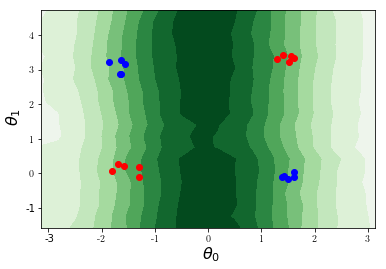

[3.0672044712460114, 3.3311348339721203]


In [33]:
plot_decision_boundary(init_list_params,'init_boundary_qpu.pdf')
print(init_list_params)

In [37]:
# Callback function for displaying progress
Nfeval = 1
min_loss_history = []
    
def callback_func(input_params):
    global Nfeval
    global min_loss_history
    loss = targetfunc_q0(input_params)
    list_display = [Nfeval]
    list_display.extend(input_params)
    list_display.append(loss)
    Nfeval += 1
    min_loss_history.append(loss)
    
def targetfunc(x):
    try:
        return targetfunc_q0(x)
    except:
        return targetfunc_q0(x)
    
# Train the classifier
res = minimize(targetfunc, init_list_params, args=(), method='Nelder-Mead', tol=1e-2, 
                       callback=callback_func,
                       options={'disp': False,
                                 'initial_simplex': init_simplex,
                                 'maxiter': 20,
                                 'xatol': 0.01,
                                 'return_all': False,
                                 'fatol': 0.01})


Group 0

Job ID: CqIQGsOBbqUbRwMY

Probability: 0.383

Job ID: xZQpzhwdqnptisnQ
Job failed. Trying again...

Job ID: fMjkVPvRJwznsbqg

Probability: 0.5664
Job failed. Trying again...
Job failed. Trying again...

Job ID: NTvMwOsJsSfRCqFy

Probability: 0.5647

Job ID: SJeWIdjrWJIEzrYs

Probability: 0.438
Job failed. Trying again...

Job ID: iBvOZdwwqpMcLLGk

Probability: 0.4807
Job failed. Trying again...

Job ID: nRKgaRBdIRklKxsm

Probability: 0.4773

Job ID: dAiJUMEpnKpkkhTW

Probability: 0.4496
Job failed. Trying again...

Job ID: eaewCwoqWSgopzPi
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: SUxoOOiecGdJVLyL
Job failed. Trying again...

Job ID: hQppwZaCqwCGzDEL
Job failed. Trying again...

Job ID: fBKwRcnMfFMNGjGn

Probability: 0.5383
Job failed. Trying again...

Job ID: uBxHKOltGAZljQEH
Job failed. Trying again...

Job ID: pNkthblXsqmXxwvQ

Probability: 0.4666
Job failed. Trying again...

Job ID: kJrPZuqnVdyP


Job ID: vTdYZTNnsMlELosH

Probability: 0.2604

Job ID: QiNMXAgveeOkiPtV

Probability: 0.3397
Job failed. Trying again...
Job failed. Trying again...

Job ID: nXmBElEcHYRCtgiS

Probability: 0.2873
Job failed. Trying again...

Job ID: nJNDHpLLsfKkDjxz

Probability: 0.3018
Job failed. Trying again...

Job ID: vICYglrANjpABWTB

Probability: 0.3352
Output=0.5401101034015157
Group 0

Job ID: NTqArkRroiQDZMpH

Probability: 0.2061

Job ID: gxvaKduzWZmwgMGk

Probability: 0.1444

Job ID: sQQAtZrybMPpZedS
Job failed. Trying again...

Job ID: ccmcnDezjUqKhIor

Probability: 0.1327

Job ID: DpdUkuDHfiObvonK

Probability: 0.1932

Job ID: XfiOSsAeSDpjLKpW

Probability: 0.1733

Job ID: nIoQJFnAYCNjsOIU

Probability: 0.1176

Job ID: rfxjOToJVtBFBkig
Job failed. Trying again...

Job ID: MrYvucyJWOWaOFuI
Job failed. Trying again...
Job failed. Trying again...

Job ID: DazacaPZmNIPqLXP
Job failed. Trying again...

Job ID: PndBfvGJJrKXkPsB
Job failed. Trying again...

Job ID: oYjYgiWTcorkpqfA
Job failed. T


Probability: 0.568

Job ID: jfGnEvfbBesywZlL

Probability: 0.5287

Job ID: AyuWoqGUBZVVuaPz

Probability: 0.4523
Job failed. Trying again...

Job ID: hyHFBAuXPiwwxJfr

Probability: 0.5113

Job ID: LzxwrtIewRqRYWIg

Probability: 0.4131
Group 1

Job ID: vGhzorJlgYhGkyMi

Probability: 0.4327
Job failed. Trying again...

Job ID: uGVQnPGhxorxHlvK
Job failed. Trying again...

Job ID: bfvesrkvzgeoGSUw
Job failed. Trying again...
Job failed. Trying again...

Job ID: ACdycORjABmcCNnq

Probability: 0.3989

Job ID: AdhCpPvRqwJKXxgv

Probability: 0.5168

Job ID: HxkfeEXsdZkrePwp

Probability: 0.429

Job ID: QWhRlBjqkumhvnqx

Probability: 0.4428

Job ID: KoKDPwDRDlyPVoGy

Probability: 0.348

Job ID: YApmxtZAbrUVrPCZ
Job failed. Trying again...

Job ID: CKuhuQaQzxGrFNDD
Job failed. Trying again...

Job ID: PieYouByukSerNvP

Probability: 0.4131

Job ID: TAFwxwSlSeLxqYAk
Job failed. Trying again...

Job ID: XLVZyoMBkGGJXyQq

Probability: 0.3534

Job ID: nMkTSeiPmmskOFyK

Probability: 0.3874

Job ID: 


Probability: 0.1401
Job failed. Trying again...
Job failed. Trying again...

Job ID: cYjzHXbjExttvwXy

Probability: 0.1329

Job ID: iYqXEARmGHcpwhhX

Probability: 0.1423
Group 1

Job ID: ozkEahQDXPpgscCd
Job failed. Trying again...

Job ID: EYMkjaTUKYMkLTsD

Probability: 0.8151
Job failed. Trying again...

Job ID: MLuOfkiIotokqLuG

Probability: 0.8444

Job ID: OTGrKmUniTMUVBrB

Probability: 0.823

Job ID: cdpuWwUdKFvFAzeV
Job failed. Trying again...

Job ID: ZpBadvgwgwklAiRZ
Job failed. Trying again...

Job ID: htMfiaSmcKpOTwAJ

Probability: 0.8316
Job failed. Trying again...

Job ID: ChmUiqqYnctaffQH

Probability: 0.8273

Job ID: OscQiDVuIclZqVIM

Probability: 0.7964

Job ID: NScRbREAYrChworh

Probability: 0.8049

Job ID: GbKknyaibcWWEFKP

Probability: 0.8046

Job ID: CpBUJtKIwfiyeCGj

Probability: 0.8034

Job ID: sTPRetJcIGKPtJhh

Probability: 0.792
Output=-1.6952755172413212
Group 0

Job ID: iWTgSlzcSDeupcyP
Job failed. Trying again...

Job ID: LeSzdxUrPMozQQfJ

Probability: 0.216



Job ID: UZEjMLfoPvOfWDGJ

Probability: 0.735
Job failed. Trying again...

Job ID: cEOputZyfNvGhDjS
Job failed. Trying again...

Job ID: JFaLlEkEDLJSpvGa
Job failed. Trying again...

Job ID: uPvgQBrZVgAlWeaY

Probability: 0.7826

Job ID: TpNxdsXjxwAkgjyK

Probability: 0.7543
Job failed. Trying again...

Job ID: FqgnuvvFnecdcsFr

Probability: 0.7715

Job ID: BkIZhiiHnbHoClyp
Job failed. Trying again...

Job ID: KouFIRJrhWPUcbuh
Job failed. Trying again...

Job ID: yLyvnWORGIMxbLdQ

Probability: 0.7471
Output=-1.773382144211164
Group 0

Job ID: DiwtVcTxdrEelCeF

Probability: 0.1502
Job failed. Trying again...

Job ID: JATIPyonlGgxZChJ

Probability: 0.1484

Job ID: WBlHyfSyLIUxmzPd

Probability: 0.1583

Job ID: VeggBeieAZOWlhBk

Probability: 0.1489

Job ID: LszGmUGrvbZoPGrV

Probability: 0.1285

Job ID: lajOLvaQzLjNmhCt
Job failed. Trying again...

Job ID: RhCzkOWLJFqJKZHf
Job failed. Trying again...
Job failed. Trying again...

Job ID: aTtezojGzKepnPnW

Probability: 0.0904

Job ID: YYGOA


Probability: 0.7242

Job ID: ydhurNQeafoUdEGl

Probability: 0.7295
Job failed. Trying again...

Job ID: lPviPWUKhUkspsBK
Job failed. Trying again...
Job failed. Trying again...

Job ID: tNPLKCEYFamrfijz
Job failed. Trying again...

Job ID: ZBNnLcnaurZOioXi
Job failed. Trying again...

Job ID: rHxSHgVMrGWhepKn

Probability: 0.6935
Output=-1.9743768138197264
Group 0

Job ID: lnLxFtYGIhfkzYzJ

Probability: 0.1341

Job ID: HpqtuygvGblwzaFr
Job failed. Trying again...

Job ID: WNSwKgoYgBORZQcL

Probability: 0.1194

Job ID: tpZUfDsJEsuRsYwf

Probability: 0.1156

Job ID: NVofjFsFeRazLSsl

Probability: 0.1171
Job failed. Trying again...

Job ID: TGbbxhrrGuecEHWD
Job failed. Trying again...

Job ID: hDJLGOWDJrgNKhiy

Probability: 0.1164
Job failed. Trying again...

Job ID: WGYcMgHGtTKJqFnA

Probability: 0.0681

Job ID: kHCuFHyztGcEJbxP

Probability: 0.0756
Job failed. Trying again...

Job ID: nAadOAhVlghSfJjy
Job failed. Trying again...

Job ID: eqPkrCVvUPzrhsCS

Probability: 0.072
Job failed.


Job ID: vtdBFUxSnSduRVqX

Probability: 0.1624

Job ID: SJdGBWRXRghLfpxQ

Probability: 0.144
Job failed. Trying again...

Job ID: zRoEjjupJppDwaLR

Probability: 0.0699

Job ID: ifopKJfKqjHaQngd

Probability: 0.0758
Job failed. Trying again...

Job ID: bOhHPXdkFRIhMPaw
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: JDlWOeWjOHLmwzsH

Probability: 0.0804
Job failed. Trying again...

Job ID: VmQTMPreZMCkCFnU
Job failed. Trying again...

Job ID: DLaeFFCdqVgQlJYs
Job failed. Trying again...

Job ID: dwMmvKTVXQOyonUr
Job failed. Trying again...

Job ID: gPKOisSKdkcJmRKW

Probability: 0.0763

Job ID: zQzpJxCvQTtfrbYZ
Job failed. Trying again...

Job ID: VRWiKaMEkXpMtsjo
Job failed. Trying again...

Job ID: YQpZAzHhtkFEwEkp
Job failed. Trying again...

Job ID: oaoviWMejCwoyWnF
Job failed. Trying again...

Job ID: nyRZjlggqLIBHGlw

Probability: 0.0709
Group 1

Job ID: pbJYayOjOXkhLhLS

Probability: 0.7943

Job ID: fsumbJYvCARyWMxh

Probability: 0.816


Probability: 0.1086

Job ID: zdmQJrjSbKeRlcgs

Probability: 0.1155

Job ID: tAwZNkLJodiOwVcD

Probability: 0.0598

Job ID: FTfcnrftaCatOHXW
Job failed. Trying again...
Job failed. Trying again...

Job ID: CMWgxFHJlBMGJZVq

Probability: 0.0591

Job ID: sRJnPnxxjzKGaplc

Probability: 0.0653

Job ID: enzrqTYrWThnCvHf
Job failed. Trying again...
Job failed. Trying again...

Job ID: GSgUovxfdTEfPkTI
Job failed. Trying again...
Job failed. Trying again...

Job ID: yBkUCCSlqbPTUhYS
Job failed. Trying again...

Job ID: itydHgKFWwydCijb
Job failed. Trying again...
Job failed. Trying again...

Job ID: NlQYbyaTFdyimSoI

Probability: 0.0693
Job failed. Trying again...

Job ID: jgiCUmkzFdtNLNoH
Job failed. Trying again...

Job ID: WvuRGdvTHLDujcaZ

Probability: 0.0546
Group 1

Job ID: VdXKBfblWoRhVxLV

Probability: 0.7719

Job ID: eYjsGyguGBHVAelh
Job failed. Trying again...

Job ID: FkugHBqdTQUKhWUh

Probability: 0.7983

Job ID: lZcNYNwWrpGeVHBy

Probability: 0.7928

Job ID: GBSxxkFuvVzcYFZj

Pro


Probability: 0.1486

Job ID: dUuOgMxonHwnZFId
Job failed. Trying again...
Job failed. Trying again...

Job ID: RCOcoKmfGUtqOoDG

Probability: 0.1307

Job ID: STlnWLgqjWZPgXFE
Job failed. Trying again...

Job ID: ylxMbfPEhvdAqzpK

Probability: 0.1211

Job ID: ETNDnDMSffjkluiG
Job failed. Trying again...

Job ID: wwZngJtbQWSYiVsf

Probability: 0.1202

Job ID: XaLHtLmtAMkrVaCi
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: MaUxebEkCzBcckXa
Job failed. Trying again...

Job ID: MCXIDriQwmLHLNpi

Probability: 0.1098
Job failed. Trying again...

Job ID: HTcFrDHgQQpnKUAL
Job failed. Trying again...

Job ID: FJsYCpyQjTCcFGXX

Probability: 0.0356

Job ID: TsexKPGVKPtYBDAh

Probability: 0.0508

Job ID: KDfSivxPhSornTfp

Probability: 0.0569

Job ID: oXoOVIjglaMQYTRs
Job failed. Trying again...

Job ID: berSCryeLTpJgFOi
Job failed. Trying again...

Job ID: RMSAUPlQvIyWADYb

Probability: 0.0478
Job failed. Trying again...

Jo

Job failed. Trying again...

Job ID: cUnnYBpTyuyGeZTD
Job failed. Trying again...
Job failed. Trying again...

Job ID: eClUHCOtQsBnnKMO

Probability: 0.0859
Job failed. Trying again...

Job ID: parSKsHkieJvotPS
Job failed. Trying again...

Job ID: oywNxXoIYNEqlRbR

Probability: 0.0798

Job ID: QHOGJGmsPxMXvkkU

Probability: 0.0956

Job ID: pWEsPQVQyUZiEDEi

Probability: 0.0757

Job ID: TCMoInKxHoEBjSGy
Job failed. Trying again...

Job ID: motLWlJnzCsjSPvq

Probability: 0.0332

Job ID: dAOefGeJOBCFmvdf

Probability: 0.0375

Job ID: SNEoXWTODdzhbNHn

Probability: 0.0418
Job failed. Trying again...

Job ID: dzHExBznJKpZaESU

Probability: 0.0371

Job ID: pufgLTfAITfhzcdf

Probability: 0.0406
Group 1

Job ID: TxbubaDtprqByYhh

Probability: 0.6633
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: usZXHmjoDbcTrAvE

Probability: 0.6707
Job failed. Trying again...

Job ID: wMXQxaxCLVaMapEu

Probability: 0.5487

Job ID: HyCjUhplgoiGHedD
Job failed. Tryi


Probability: 0.031

Job ID: JeRKxxaXxLZemoKd

Probability: 0.0426
Group 1
Job failed. Trying again...

Job ID: ODpsJDyIHsfbewGi

Probability: 0.52

Job ID: QkrGaIMRdWWfZONW

Probability: 0.535

Job ID: xHuBpwCcxCtCwctg

Probability: 0.5109

Job ID: ueXapuCzYYiwUYHY
Job failed. Trying again...

Job ID: oPhnafNXoWVEYZqg

Probability: 0.5389
Job failed. Trying again...
Job failed. Trying again...
Job failed. Trying again...

Job ID: ctjaqySTDbeegExp
Job failed. Trying again...

Job ID: yciEvGKJwfdLsNMx
Job failed. Trying again...

Job ID: kOEULrIoIOuwWWdS

Probability: 0.5272

Job ID: ZxNqMQTfhySXoQzH
Job failed. Trying again...

Job ID: gDNKSuSoQzCOWyAc

Probability: 0.4848

Job ID: AlyMDKsXgrtNdjvd

Probability: 0.4719

Job ID: laWGKKPBrQXSSwwS

Probability: 0.4846

Job ID: KcBMQjvstMdqiXIJ
Job failed. Trying again...

Job ID: KmnwbGgReFbEMLLr

Probability: 0.4588

Job ID: EGBUhNQGTmkkAlDC

Probability: 0.4759
Output=-2.420353160495953
Group 0

Job ID: dSTAfBYDaWInqsAV
Job failed. Tryi


Probability: 0.0843
Group 1

Job ID: cWNikOaaEiHmWxWy

Probability: 0.7956
Job failed. Trying again...

Job ID: hifaXGDzAMQISWZL

Probability: 0.82
Job failed. Trying again...
Job failed. Trying again...

Job ID: BfkXfJSfLAkIfcNh
Job failed. Trying again...

Job ID: dvynFqcGzjtFNeLk

Probability: 0.8039

Job ID: gGoOdNWfVxKfoUmc

Probability: 0.8158
Job failed. Trying again...

Job ID: zyjwbZhDVRJJalLz

Probability: 0.8074

Job ID: TydtDAebEvATcKeK

Probability: 0.7117

Job ID: VzfgpHuCNnUsSmFP

Probability: 0.7274

Job ID: uGxGzhJGGMfJXyiV

Probability: 0.6599

Job ID: QYfreQyMcmlyHnnb

Probability: 0.6831

Job ID: wiMQTeJAxBWwbGlN

Probability: 0.6708
Output=-1.9446850110471587
Group 0

Job ID: oaWkWNfkpBPRaAut

Probability: 0.1325

Job ID: MTWbNpAXRDMwSpBi

Probability: 0.129

Job ID: gXAGQJtSVxMusmDt

Probability: 0.1405

Job ID: sVWESZdkOgGQkLQj

Probability: 0.142

Job ID: IANwdsiAdsGCgsaq

Probability: 0.1122
Job failed. Trying again...

Job ID: CBmpDDStVwITwKOV

Probability: 0

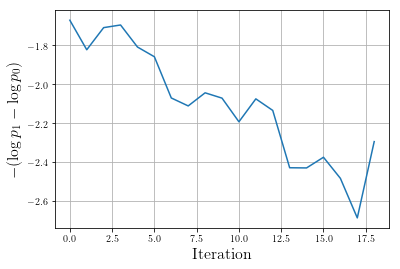

In [38]:
# Plot training curve
plt.plot(range(0,len(min_loss_history)), min_loss_history)
plt.grid('on')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlabel(r'Iteration',fontsize=16)
plt.ylabel(r'$-(\log p_1-\log p_0)$',fontsize=16)
plt.savefig('training_curve.pdf')
plt.show()

In [39]:
# Print decision boundary performing a grid evaluation of the optimized circuit
params = res.x

Nmesh = 20
range0 = np.linspace(-pi,pi,Nmesh)
range1 = np.linspace(-pi/2,pi+pi/2,Nmesh)

range_inputs = []
func_vals = []

for x in range0:
    print('x={}'.format(x))
    for y in range1:
        print('y={}'.format(y))
        range_inputs = range_inputs + [[x,y]]
        func_vals = func_vals + [evaluate_q0([x,y], params, qubits_chosen)]

x=-3.141592653589793
y=-1.5707963267948966

Job ID: fqfsqsVaQKXPbrft

Probability: 0.4502
y=-1.2401023632591288
Job failed. Trying again...

Job ID: vAGFMNtOBtRlYIHJ
Job failed. Trying again...

Job ID: QcsLsPfIneQZIDjT

Probability: 0.4371
y=-0.9094083997233612

Job ID: MftySItVmzALEXdB

Probability: 0.436
y=-0.5787144361875936
Job failed. Trying again...

Job ID: OZjWOZhdhygJDWdb

Probability: 0.4284
y=-0.2480204726518258

Job ID: fcjcZnqhKbQLMcEZ
Job failed. Trying again...

Job ID: jaQaYLgcaabyFuaq

Probability: 0.4315
y=0.08267349088394194
Job failed. Trying again...
Job failed. Trying again...

Job ID: PBvhlaacMTmCnUzu

Probability: 0.4518
y=0.41336745441970946
Job failed. Trying again...

Job ID: UcOYAMbjoybmIIEX

Probability: 0.4546
y=0.7440614179554772

Job ID: rXarvExLuMfYtpcE
Job failed. Trying again...

Job ID: yWmrDLtdaGaUgoTj

Probability: 0.4544
y=1.074755381491245

Job ID: yGqHMxqAvxUyuBUe

Probability: 0.4715
y=1.4054493450270127

Job ID: QCsXkeTwIxSPzPCK
Job failed. T


Job ID: EEjbdAacnAzcGYQC
Job failed. Trying again...

Job ID: yYmZXbgSWlzMRZIN
Job failed. Trying again...
Job failed. Trying again...

Job ID: mKUXwOeRCEFAJsJq

Probability: 0.7695
y=3.7203070897773864

Job ID: UKCzHPoQyShLCMsw

Probability: 0.7133
y=4.051001053313154

Job ID: YhwlilCtcMDlXakW

Probability: 0.6263
y=4.381695016848922
Job failed. Trying again...

Job ID: IKZUimePEeMxnypD

Probability: 0.5521
y=4.71238898038469
Job failed. Trying again...

Job ID: yydCDWjNUTlgOvMo
Job failed. Trying again...

Job ID: tntpWFVVFpxTuVXM

Probability: 0.4937
x=-1.8188167994467224
y=-1.5707963267948966

Job ID: PDroHJkTzJwQCoCz

Probability: 0.4909
y=-1.2401023632591288

Job ID: rkjrlkGEJaRNEUdm

Probability: 0.3364
y=-0.9094083997233612

Job ID: rLmlMwqNZtVZdMWo

Probability: 0.2736
y=-0.5787144361875936

Job ID: CoIYWNaopSLJpYOm

Probability: 0.1929
y=-0.2480204726518258
Job failed. Trying again...

Job ID: BzDPrzBLtvzVJwFP
Job failed. Trying again...

Job ID: LWIffpKeYoYsatvT
Job failed.


Probability: 0.6516
y=3.058919162705851

Job ID: GfrCRgYUWrFKKNyc

Probability: 0.6759
y=3.3896131262416187

Job ID: xErrGcJudPGYiGix

Probability: 0.6887
y=3.7203070897773864

Job ID: lcUaNigkOeskawno

Probability: 0.6632
y=4.051001053313154

Job ID: ScjmnSskhWbQjddv

Probability: 0.6098
y=4.381695016848922
Job failed. Trying again...

Job ID: IRTwGRqEnvFjtzmE
Job failed. Trying again...

Job ID: wZxkaLSeeyzQRsQm

Probability: 0.5366
y=4.71238898038469

Job ID: bRnhxTeukEPXSdNr
Job failed. Trying again...

Job ID: FTDxUxrzLCzGSDzi
Job failed. Trying again...

Job ID: fwLvsMMcFVgTPVGQ

Probability: 0.4361
x=-0.4960409453036516
y=-1.5707963267948966

Job ID: hMaedBJPKNfRZWpF
Job failed. Trying again...
Job failed. Trying again...

Job ID: BwiOZFIEPJSRQRuS
Job failed. Trying again...

Job ID: sbxGSlWFewXtTXXL

Probability: 0.4308
y=-1.2401023632591288
Job failed. Trying again...
Job failed. Trying again...

Job ID: mbWzeqMMprkSwjfa

Probability: 0.3855
y=-0.9094083997233612
Job failed. 

Job failed. Trying again...

Job ID: PjoShJBBUIDBTBMx

Probability: 0.2421
y=3.3896131262416187

Job ID: KxFTMzoyWrCQyxMc
Job failed. Trying again...

Job ID: BHzmYeszFCinjFZs

Probability: 0.2456
y=3.7203070897773864

Job ID: lnlUsbnfTqXzAULX

Probability: 0.2685
y=4.051001053313154

Job ID: lYAHVhTjBHQVXEMO
Job failed. Trying again...

Job ID: GWAHoGPUijlKjhns
Job failed. Trying again...

Job ID: GeiCsSibyTzastZY

Probability: 0.3276
y=4.381695016848922

Job ID: VSwxJtkemzKlTUfr

Probability: 0.3832
y=4.71238898038469
Job failed. Trying again...
Job failed. Trying again...

Job ID: ZOuLUnUZzWodpvTO

Probability: 0.387
x=0.8267349088394189
y=-1.5707963267948966

Job ID: efLmSBFEckFHJlRJ
Job failed. Trying again...
Job failed. Trying again...

Job ID: HNgqeEIEdcqEREbB
Job failed. Trying again...

Job ID: TRKPqPwtnHlivYCl

Probability: 0.3849
y=-1.2401023632591288
Job failed. Trying again...

Job ID: IdqOoQPaJIjXDQmP

Probability: 0.49
y=-0.9094083997233612

Job ID: IWgoMEkomRnYikew

Pr


Job ID: flyiUqmUZNWLsWGb
Job failed. Trying again...

Job ID: fsEdsQyImRkafuoR

Probability: 0.6133
y=1.074755381491245

Job ID: mqxGAEppaNvKffSv

Probability: 0.5241
y=1.4054493450270127

Job ID: RSvqsWjsTwBAucvT

Probability: 0.4576
y=1.7361433085627804

Job ID: qYVYjQjUvPDaOTMx

Probability: 0.3493
y=2.066837272098548

Job ID: czHBWOlkIexjxddw

Probability: 0.2632
y=2.3975312356343155
Job failed. Trying again...

Job ID: IBZTkvVHFiuuBwaa

Probability: 0.1821
y=2.728225199170083

Job ID: rhXjZdXnihyjHqMz

Probability: 0.1228
y=3.058919162705851

Job ID: awzPaFxlqfowREFE

Probability: 0.0851
y=3.3896131262416187
Job failed. Trying again...

Job ID: SHuGoNlQtumcLUuL

Probability: 0.0966
y=3.7203070897773864
Job failed. Trying again...

Job ID: GwQUVUUuvnZnohwc

Probability: 0.1303
y=4.051001053313154

Job ID: yYqPglwbvbpUzoAP

Probability: 0.1979
y=4.381695016848922

Job ID: uneRFnQYsfXoPGbc

Probability: 0.307
y=4.71238898038469

Job ID: LZmCPXeXwQtcYjAc

Probability: 0.3784
x=2.1495


Job ID: dldHVHhqukwETryg

Probability: 0.4652
y=2.066837272098548

Job ID: FFIGWjKZiJoctsBY

Probability: 0.4726
y=2.3975312356343155

Job ID: NKlKBicCoShArJjp

Probability: 0.4779
y=2.728225199170083

Job ID: sCMffYeHEIJYTQMU

Probability: 0.4869
y=3.058919162705851

Job ID: SHxljQdEUUtbigpp

Probability: 0.4868
y=3.3896131262416187

Job ID: KbiVRlipVFcCFoGb

Probability: 0.4761
y=3.7203070897773864

Job ID: pmWxZTYthYpPSAIE

Probability: 0.4609
y=4.051001053313154
Job failed. Trying again...
Job failed. Trying again...

Job ID: RXbEPPsfSwtFjQNp

Probability: 0.45
y=4.381695016848922

Job ID: wlxHVILceMniFbXZ

Probability: 0.4477
y=4.71238898038469

Job ID: suYAJocQjsUmtszM
Job failed. Trying again...

Job ID: gslVVVjvOWavjVzL
Job failed. Trying again...

Job ID: QJfDDrCPdHsTgCTD

Probability: 0.4623


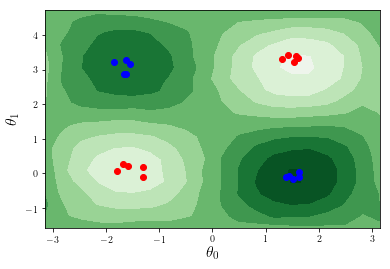

In [42]:
from matplotlib import cm

# Plot the decision boundaries
x = list(np.kron(range1, [1 for i in range(0,Nmesh)]))
#y = list(np.kron([1 for i in range(0,Nmesh)], range0))
X, Y = np.meshgrid(range0, range1)

# colors = func_vals
Z = np.reshape(func_vals, [Nmesh, Nmesh])

levels = np.arange(-3.5, 3.5, 0.1)
norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
cmap = cm.PRGn

plt.contourf(X, Y, Z, levels, cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm)
plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlabel(r'$\theta_0$',fontsize=16)
plt.ylabel(r'$\theta_1$',fontsize=16)
plt.savefig('trained.pdf')
plt.show()

In [10]:
# Single parameter sweep
Nmesh = 20
range_params = np.linspace(-pi,pi,Nmesh)
fval = list(np.zeros(Nmesh))

for p in range_params:
    fval = fval + [targetfunc_q0([p])]

Group 0


IndexError: list index out of range

In [ ]:
# Plot the parameter sweeping results
plt.plot(range(0,Nmesh), fval)
plt.grid('on')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlabel(r'$w_1$',fontsize=16)
plt.ylabel(r'$-(\log p_0-\log p_1)$',fontsize=16)

plt.show()